# Differential training of a GeodesyNet
In this notebook we show the differential trainin: how to train a neural density field to represent the difference between a known, homogeneously filled, asteroid and a heterogeneous ground truth.

**NOTE: With respect to a *normal* training (see Starter Notebook) the differences in the code are minimal**. Conceptually, we are now taking advantage of a ground truth 3D model of the asteroid surface.

We suggest to run this notebook in the same conda environment as the one described in the Starter Notebook.

In [2]:
# core stuff
import gravann
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Available devices  1
__pyTorch VERSION: 1.11.0
__CUDNN VERSION: 8200
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing the ground truth asteroid
Here we load the ground truth model (mascon) used to generate synthetic acceleration readings. Note that the ground truth is heterogenous, that is its internal mass distribution is not uniform.

In [3]:
# nu will be added
# one of "bennu" "itokawa" "planetesimal"
name_of_gt = "itokawa"

In [4]:
# We load the ground truth (a mascon model of some heterogenous body)
with open("mascons/"+name_of_gt+"_nu.pk", "rb") as file:
    mascon_points, mascon_masses_nu, mascon_name = pk.load(file)
# We also load the homogenous version of the same body
with open("mascons/"+name_of_gt+".pk", "rb") as file:
    _, mascon_masses_u, _ = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses_nu = torch.tensor(mascon_masses_nu)
mascon_masses_u = torch.tensor(mascon_masses_u)


# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates
# are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of points: ", len(mascon_points))
print("Total mass (homogenous): ", sum(mascon_masses_u))
print("Total mass (heterogeneous): ", sum(mascon_masses_nu))


Name:  Itokawa non-uniform
Number of points:  41748
Total mass (homogenous):  tensor(1.0000, dtype=torch.float64)
Total mass (heterogeneous):  tensor(1.0000, dtype=torch.float64)


<IPython.core.display.Javascript object>


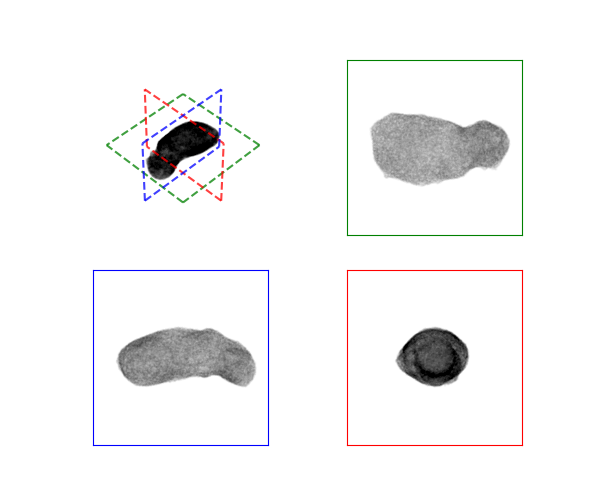

In [7]:
# Here we visualize the loaded ground truth. Darker areas,
# the head in the case of Itokawa, correspond to heavier densities.
gravann.plot_mascon(mascon_points, mascon_masses_nu,alpha=0.01)

# Representing an asteroid via a neural network


## 1 - Defining the network architecture
Here the only change w.r.t. a normal training is the activation function of the last layer
which needs to allow for negative numbers (to be able to remove mass from a homogeneous reference distribution) and is thus an hyperbolic tangent.

In [8]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final hyperbolic tangent to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation =  nn.Tanh())

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [10]:
## ---------------------------------------------------------------------------------------
## IF YOU WANT TO LOAD AN ALREADY TRAINED NETWORK UNCOMMENT HERE.
## 300000 points used for the quadrature, 1000 for batches and trained for 20000 epochs
## If a model is preloaded skip to the later interpretation of results cells
## ---------------------------------------------------------------------------------------

model.load_state_dict(torch.load("models/"+name_of_gt+"_nu_dl.mdl"))
# Once a model is loaded the learned constant c (named kappa in the paper) is unknown 
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses_nu, use_acc = True)

C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 2 - Visualizing an asteroid represented by the network
The network output is the neural density in the unit cube. Since we are now modelling a density difference, negative values are also present and a rejection plot must be called twice to visualize the positive values (red) and the negative (blue)

In [ ]:
fig = gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=2, bw=True, color = 'b')
gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=2, bw=True, color = 'r', figure = fig);

plt.title("Differential neural density field: untrained")

# Differential training of a geodesyNet

In [ ]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 300000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 1000

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = gravann.normalized_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = gravann.ACC_trap

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/"+name_of_gt+"_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0.0,1.0])
# Here we set the optimizer
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-6,verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

... so far all is identical to the normal training ... in the next cell, note how the only difference is on the definition of the labels.

In [ ]:
# TRAINING LOOP (differential training, use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(20000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        # These are the difference between a homogeneous and an inhomogenous ground truth
        labels_u = gravann.ACC_L(target_points, mascon_points, mascon_masses_u)
        labels_nu = gravann.ACC_L(target_points, mascon_points, mascon_masses_nu)
        labels = labels_nu - labels_u
    
    # We compute the values predicted by the neural density field
    predicted = mc_method(target_points, model, encoding, N=n_quadrature)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())  
        
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((n_quadrature*batch_size) // 100000)
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

In [ ]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

### 3 - Interpretation of the neural density field learned

In [ ]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 2562it [00:03, 717.69it/s]                                                                         


<IPython.core.display.Javascript object>


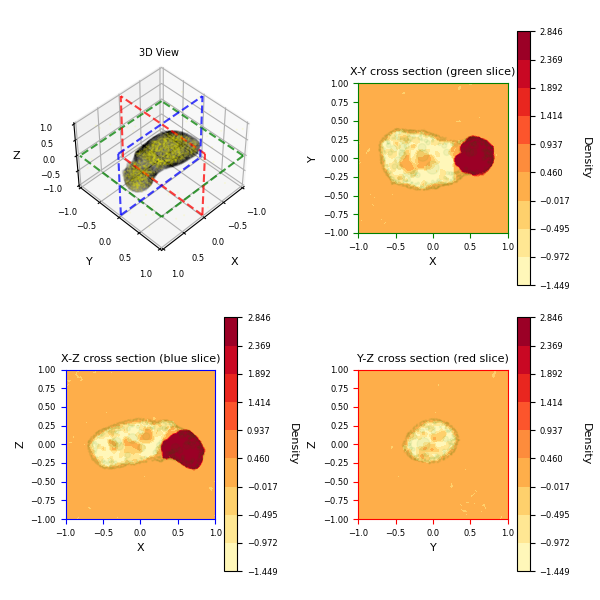

<Axes3DSubplot:title={'center':'3D View'}, xlabel='X', ylabel='Y'>

In [15]:
# Then overlaying a heatmap to the mascons 
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses_nu,c=c, progressbar = True, N=2500, heatmap=True)

In [16]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
results_geodesyNet = gravann.validation(model, encoding, mascon_points, mascon_masses_u, 
                mascon_masses_nu=mascon_masses_nu, 
                use_acc=True, 
                asteroid_pk_path="3dmeshes/"+name_of_gt+".pk", 
                N=10000, 
                N_integration=300000,  # This needs to be the same as the number used during training, else precision will be lost
                batch_size=100, 
                progressbar=True)

Computing validation...:  62%|██████████████████████████████▉                   | 48700/78672 [00:53<00:32, 927.43it/s]

Discarding 5977 of 16220 points in altitude sampler which did not meet requested altitude.


Computing validation...:  75%|█████████████████████████████████████▎            | 58800/78672 [01:29<00:51, 383.45it/s]

Discarding 10858 of 16220 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▋      | 68800/78672 [02:01<00:25, 385.68it/s]

Discarding 14419 of 16220 points in altitude sampler which did not meet requested altitude.


Computing validation...: 78800it [02:32, 518.19it/s]                                                                   


In [17]:
results_geodesyNet

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.00577,0.0043,0.105047,0.023571
1,High Altitude,0.002641,0.002229,0.071316,0.016004
2,Altitude_0,0.001608,0.00142,0.0072,0.00209
3,Altitude_1,0.001129,0.001204,0.005883,0.002106
4,Altitude_2,0.000619,0.001065,0.002696,0.001495


In [18]:
factor_planetesimal = 9.982e12 * 6.67430e-11 / 3126.6064453124995**2
factor_itokawa = 3.51e10 * 6.67430e-11 / 350.438691675663**2
factor_bennu = (7.329e10   * 6.67430e-11  / 352.1486930549145**2)
factor = factor_itokawa

In [19]:
absolute = results_geodesyNet["Normalized L1 Loss"] * factor
relative = results_geodesyNet["Normalized Relative Component Loss"] 

In [20]:
# Prints the line for the table 1 in the paper
print(f"{absolute[2]:.2e} & {absolute[3]:.2e} & {absolute[4]:.2e} & {relative[2]*100:.2f} & {relative[3]*100:.2f} & {relative[4]*100:.3f}")

3.07e-08 & 2.15e-08 & 1.18e-08 & 0.14 & 0.12 & 0.106


#### Saving the model

In [ ]:
# Uncomment to save to models/
torch.save(model.state_dict(), "models/"+name_of_gt+"_nu_dl.mdl")